Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Experiment Management with MLFlow

This tutorial shows how to use common MLFlow functionalities to management MONAI experiments. The MONAI example used here is [3D spleen segmentation](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb).

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

## Setup environment

`MLFlow` comes as part of the `monai[all]` installation. For official documentation on MLFlow's experiment management functionalities, click [here](https://www.mlflow.org/docs/latest/tracking.html).

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"

## Setup imports

In [ ]:
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from monai.visualize import blend_images
import torch
import tempfile
import shutil
import os
import glob
import mlflow
import matplotlib.pyplot as plt

print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [ ]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set up MLFlow tracking

**This is a very important cell for tracking. If this is your first time using this, please read the following description in its entirety before proceeding.**

For ease of use, we set up tracking locally. There are other options available, some of which are remote; find them [here](https://www.mlflow.org/docs/latest/tracking.html#where-runs-are-recorded).

You can specify an `experiment_name` and a `run_name`. In the sample interface shown below, `experiment_name` is used to organize the tabs on the left (e.g., "Experiment 1"), while `run_name` is used to organize the chart within each tab (e.g., "test" and "test2").

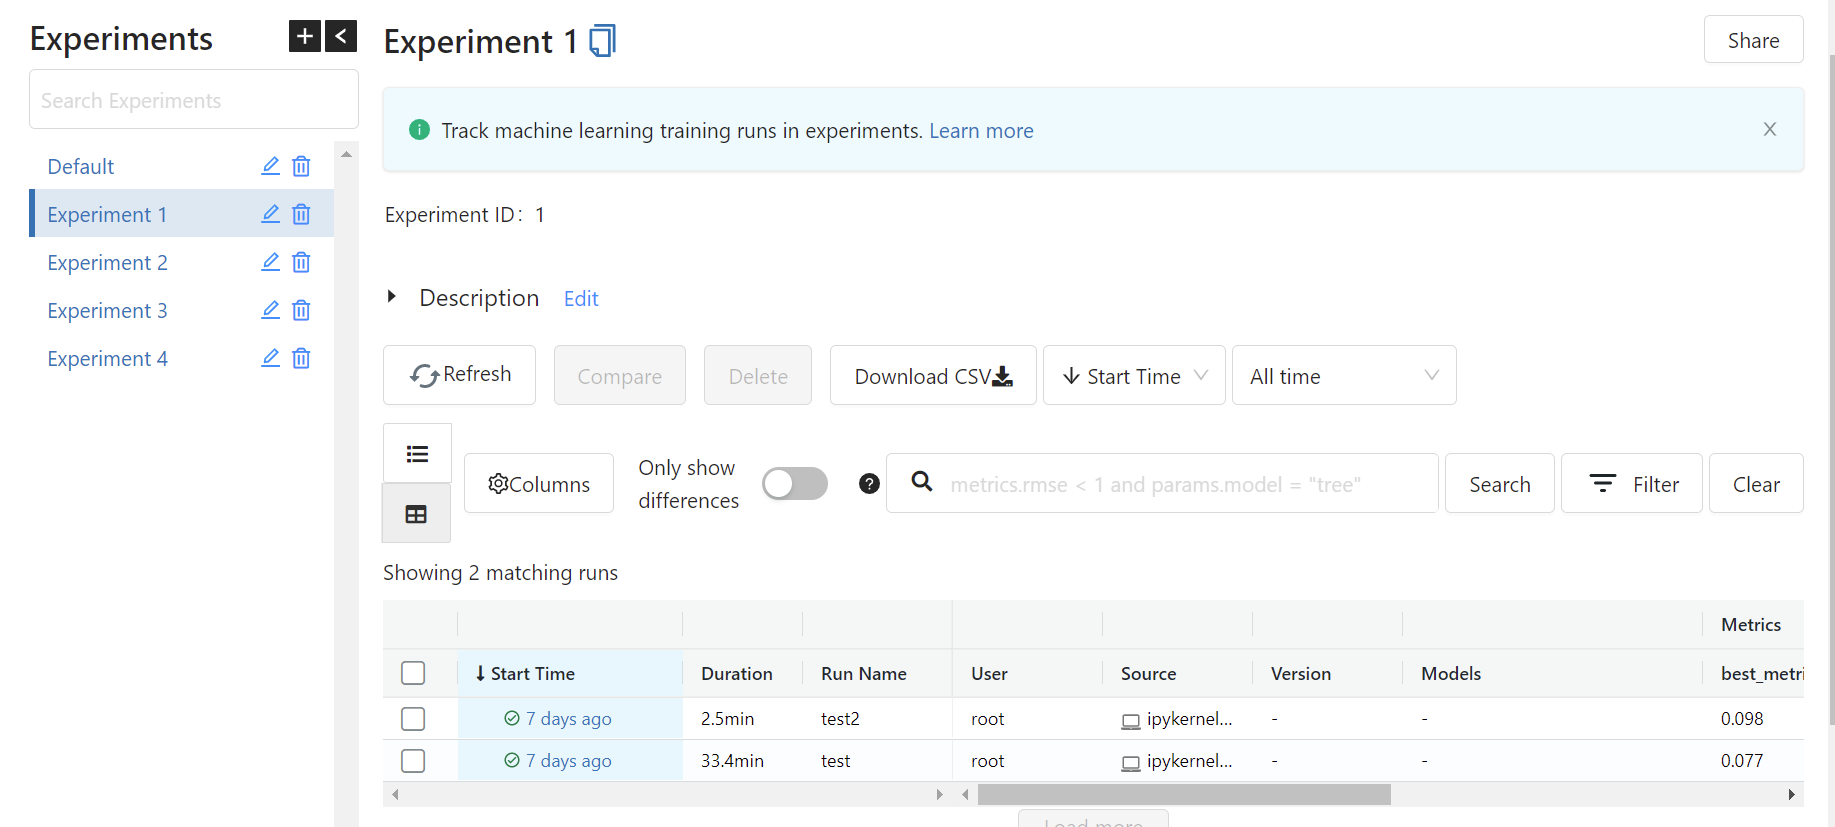

`set_experiment` will automatically place the current experiment-run in its appropriate location, creating a new experiment if necessary.

MLFlow does not currently have support for auto-logging in regular PyTorch, so we will log the run manually. Here we start the run; note that it is best practice to **end the run after you finish this experiment** (the code is provided at the very end).

In [ ]:
experiment_name = "Spleen_3D_segmentation"
run_name = "test"
experiment = mlflow.set_experiment(experiment_name)
mlflow.start_run(run_name=run_name)

## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Setup transforms for training and validation

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

## Set up visualization

This cell is needed and only needed for overlay visualizations. It contains a helper function that uses MONAI's `blend_images`. We will use this function to plot a sample image during validation.

You are welcome to add or replace with your preferred method of visualization. For other visualizations supported by MONAI, check out this [tutorial](https://github.com/Project-MONAI/tutorials/blob/main/modules/transform_visualization.ipynb).

Here is a sample output of our selected visualization, from step 200. It is known and expected that the prediction overlay will appear erratic in early epochs.

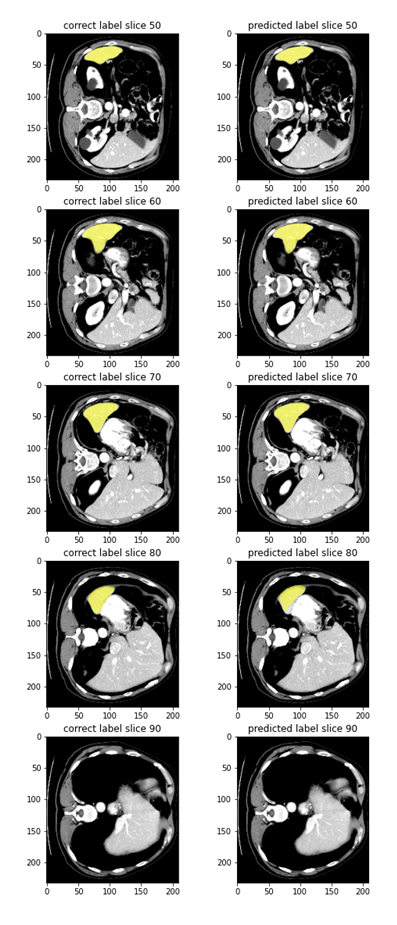

In [ ]:
def render(image, label, prediction, show=False, out_file=None, colormap="spring"):
    """
    Render a two-column overlay, where the first column is the target (correct) label atop the original image,
    and the second column is the predicted label atop the original image.

    Args:
        image: the input image to blend with label and prediction data.
        label: the input label to blend with image data.
        prediction: the predicted label to blend with image data.
        show: whether the figure will be printed out. default to False.
        out_file: directory to save the output figure. if none, no save happens. default to None.
        colormap: desired colormap for the plot. default to `spring`. for more details, please refer to:
            https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    correct_blend = blend_images(image=image, label=label, alpha=0.5, cmap=colormap, rescale_arrays=False)
    predict_blend = blend_images(image=image, label=prediction, alpha=0.5, cmap=colormap, rescale_arrays=False)
    lower, rnge = 5, 5
    count = 1
    fig = plt.figure("blend image and label", (8, 4 * rnge))
    for i in range(lower, lower + rnge):
        # plot the slice 50 - 100 of image, label and blend result
        slice_index = 10 * i
        plt.subplot(rnge, 2, count)
        count += 1
        plt.title(f"correct label slice {slice_index}")
        plt.imshow(torch.moveaxis(correct_blend[:, :, :, slice_index], 0, -1))
        plt.subplot(rnge, 2, count)
        count += 1
        plt.title(f"predicted label slice {slice_index}")
        plt.imshow(torch.moveaxis(predict_blend[:, :, :, slice_index], 0, -1))
    if out_file:
        plt.savefig(out_file)
    if show:
        plt.show()
    return fig

## Define CacheDataset and DataLoader for training and validation

In [ ]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

## Create Model, Loss, Optimizer

There are three main types of logging in MLFlow:
- `log_param` and `log_params`, for logging anything that is "onetime" for each experiment-run, including model parameters and other hyperparameters. **An error will be thrown if the same parameter name is logged more than once in the same run.**
- `log_metric` and `log_metrics`, for logging numerical values during training. **Epoch numbers need to be specified**; otherwise, MLFlow will report a conflict error.
- `log_artifact` and `log_artifacts`, for logging files that will be associated with this experiment-run.

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")

# easily save all model arguments
UNet_metadata = {
    "spatial_dims": 3,
    "in_channels": 1,
    "out_channels": 2,
    "channels": (16, 32, 64, 128, 256),
    "strides": (2, 2, 2, 2),
    "num_res_units": 2,
    "norm": Norm.BATCH,
}
model = UNet(**UNet_metadata).to(device)
# log_params takes a dictionary
mlflow.log_params(UNet_metadata)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f"optimizer_param_group_{ind}"] = {
        key: value for (key, value) in param_group.items() if "params" not in key
    }
mlflow.log_params(Optimizer_metadata)

## Train with tracking

You can open a terminal in the same directory and run `mlflow ui &` (if there is a port conflict, use `--port` to specify a different one) to see the tracking UI. By default, the address will be `http://127.0.0.1:5000`. Note that the run does not have to be ended for you to open the UI.

In the figure below, we show the three main types of information that can be tracked: parameters, metrics, and artifacts.

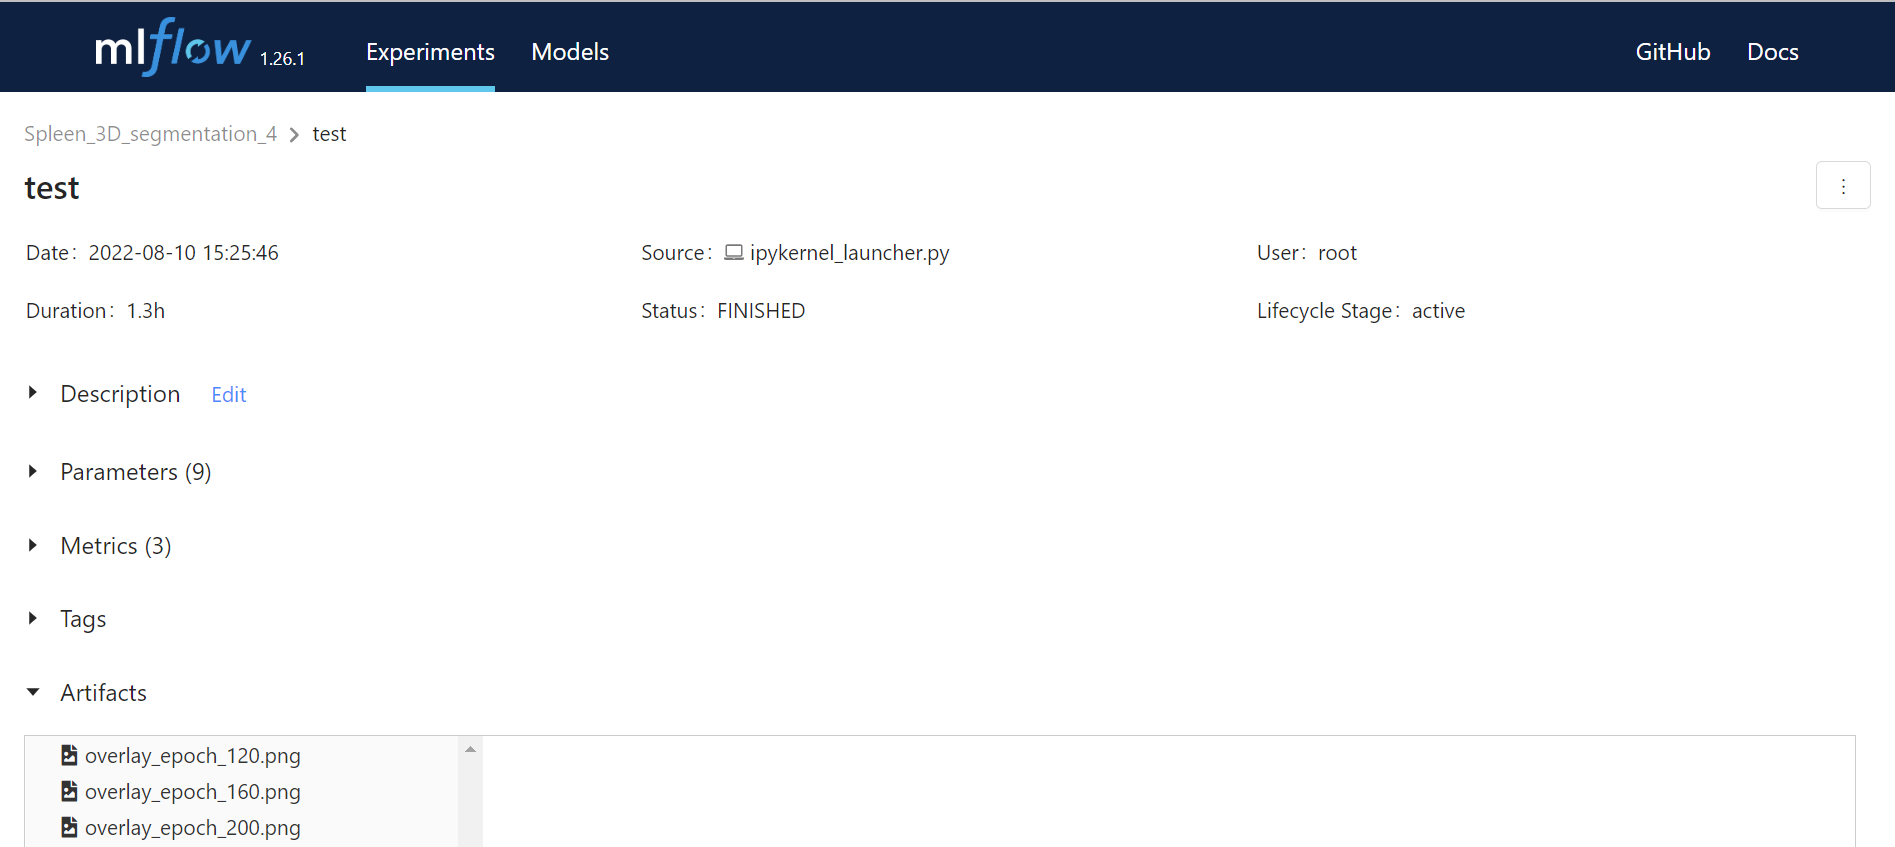

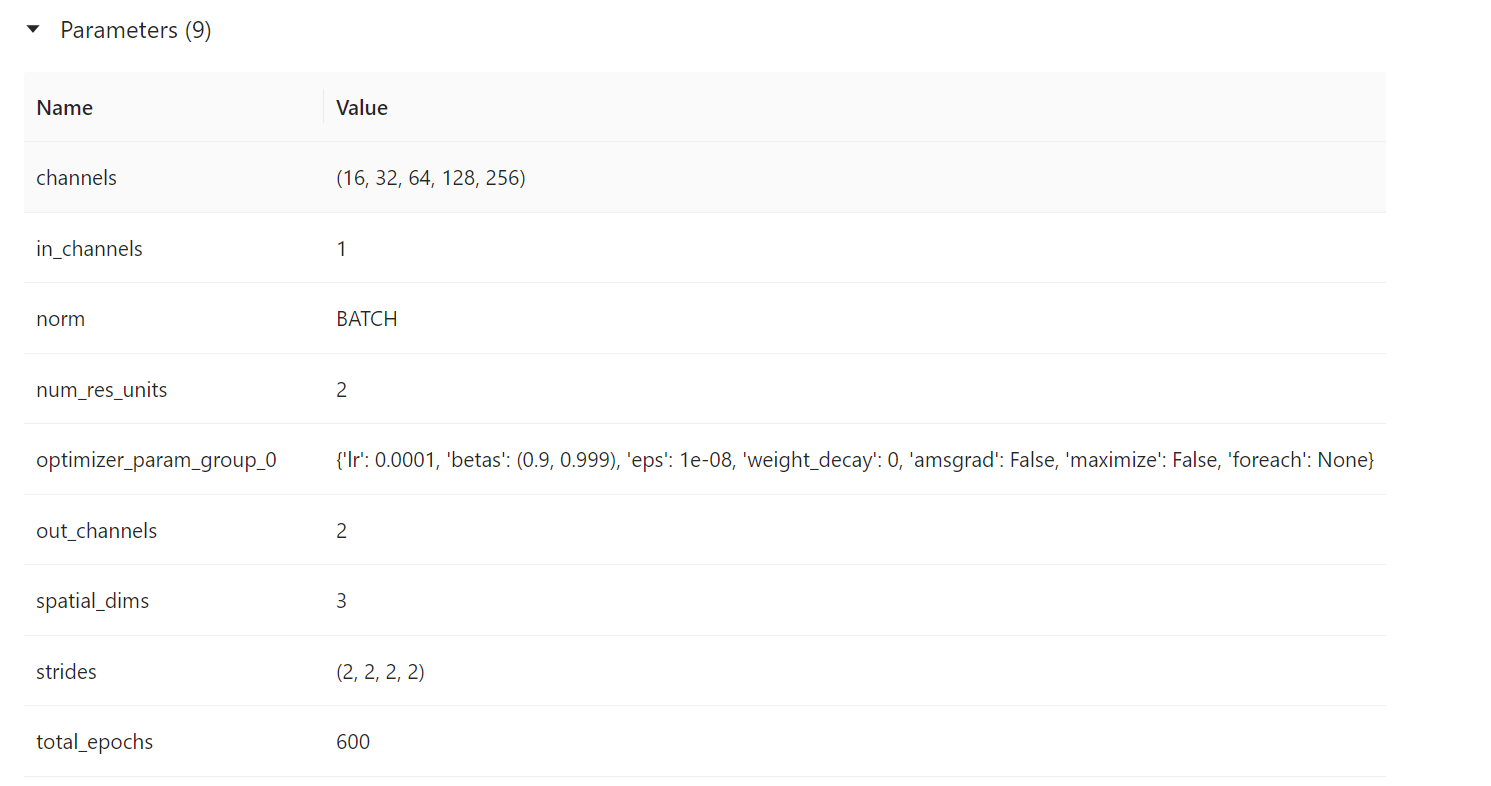
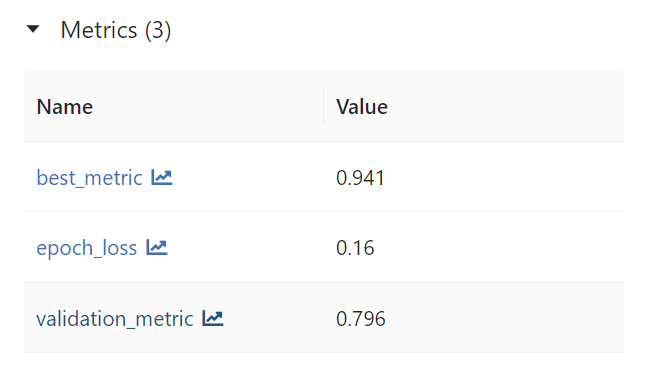

The generated overlays can be seen under artifacts.

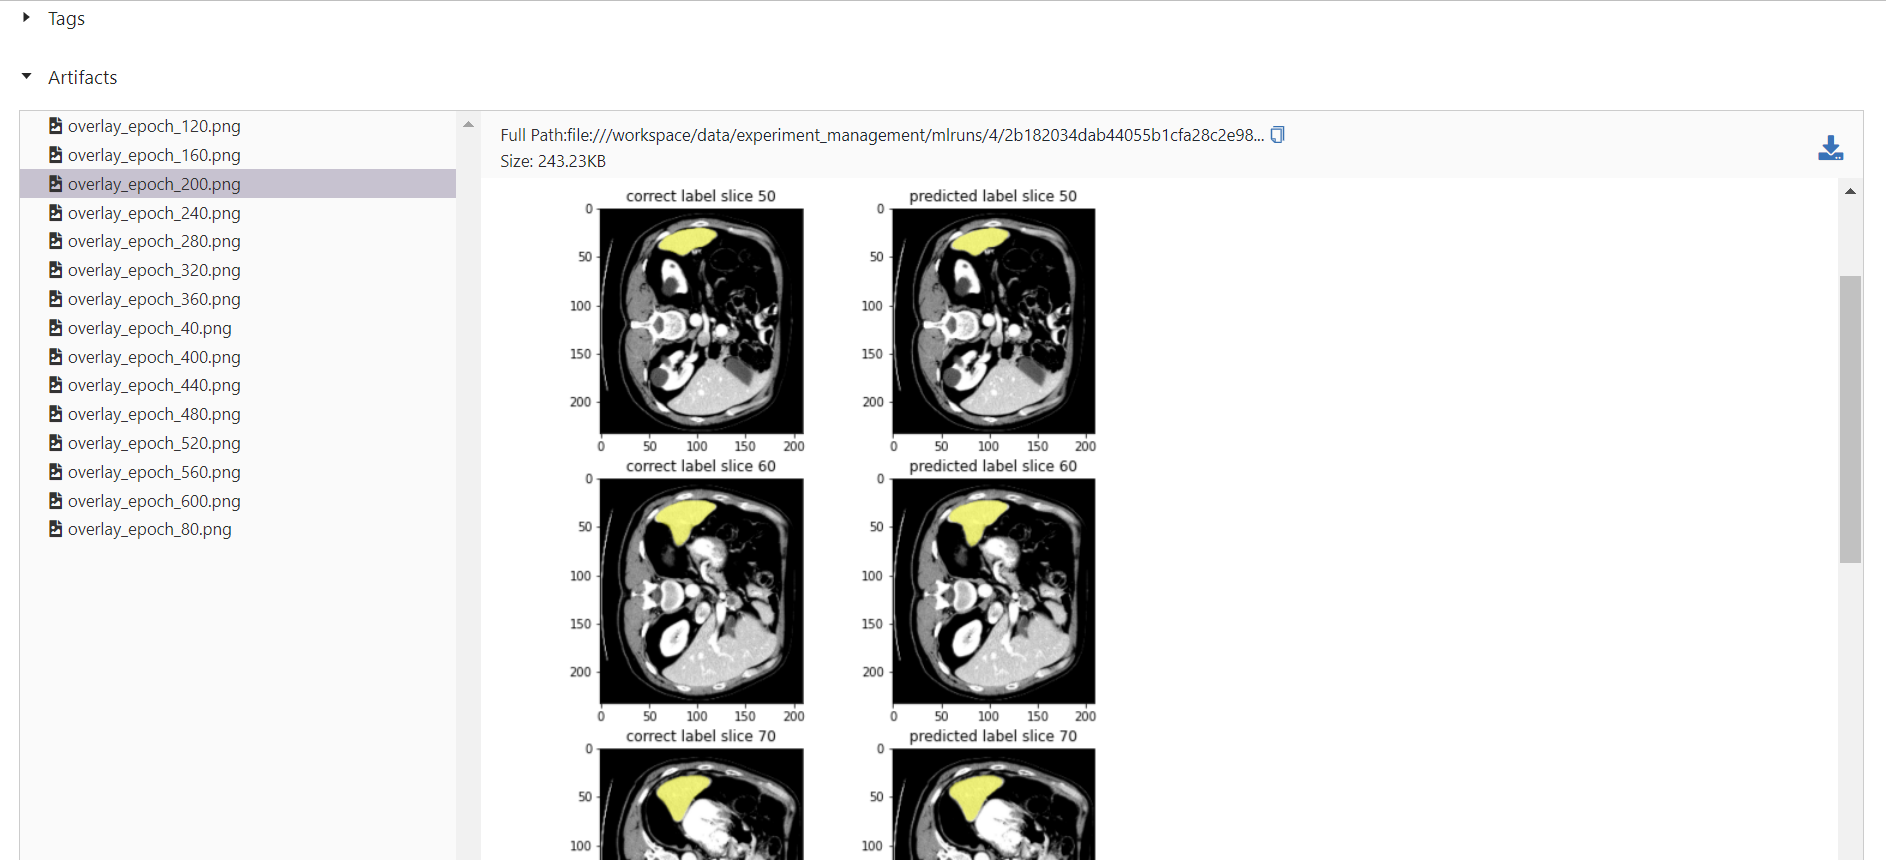

Note that the overlay visualizations can take up a non-trivial amount of disc space and use a non-trivial amount of time. If you only want the final result, set `save_overlay_interval` equal to `max_epochs`. 

We have placed overlay within validation for now, so `save_overlay_interval` also needs to be divisible by `val_interval`, but you can customize its usage to your needs.

In [ ]:
# the original segmentation was run with 600 steps; to see a quick example, use 8 steps
max_epochs = 8
val_interval = 2
# use this to specify how often you want to save 3D visualizations
# need to set this to 1 manually when running runner.sh
save_visual_every = 1
mlflow.log_param("total_epochs", max_epochs)

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# logged artifacts will be stored in the local mlruns/ folder, we are using this as a tmp workspace
overlay_tmp_dir = tempfile.mkdtemp()

In [ ]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    mlflow.log_metric(key="epoch_loss", value=epoch_loss, step=epoch + 1)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # log visuals
            if (epoch + 1) % save_visual_every == 0:
                print("tracking overlay...", end="")

                # val_labels and val_outputs contain two channels, one is background and the other is spleen
                # in val_labels[0][1][None,:], [0] selects the first image, [1] selects the spleen channel, and
                # [None:] adds (back) an additional channel for the correct shape for the render function
                figure = render(
                    image=val_inputs[0].cpu(),
                    label=val_labels[0][1][None, :].cpu(),
                    prediction=val_outputs[0][1][None, :].cpu(),
                    out_file=os.path.join(overlay_tmp_dir, f"overlay_epoch_{epoch+1}.png"),
                )
                mlflow.log_artifact(os.path.join(overlay_tmp_dir, f"overlay_epoch_{epoch+1}.png"))

                print("done.")

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            mlflow.log_metric(key="validation_metric", value=metric, step=epoch + 1)

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            mlflow.log_metric(key="best_metric", value=best_metric, step=epoch + 1)
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

## Plot the loss and metric

Under "Metrics" in the MLFlow run page (shown in the previous figure), you can click on the hyperlink and see plots of loss and metric against steps. The graph would appear similar to what you can get from matplotlib.
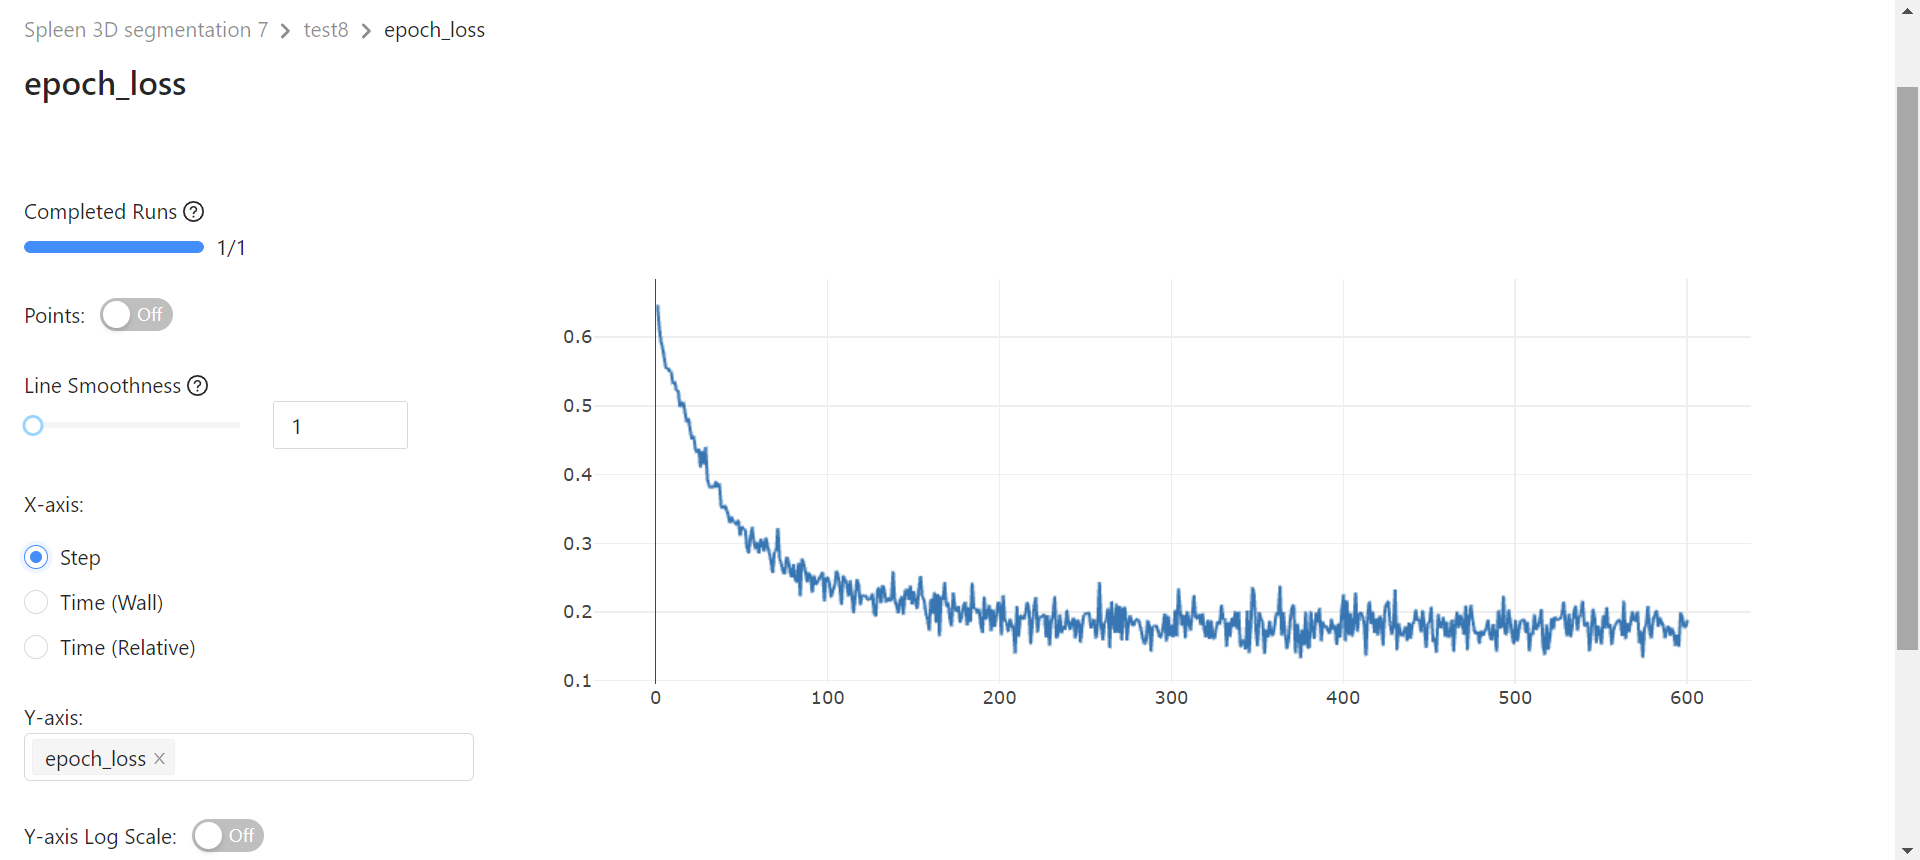
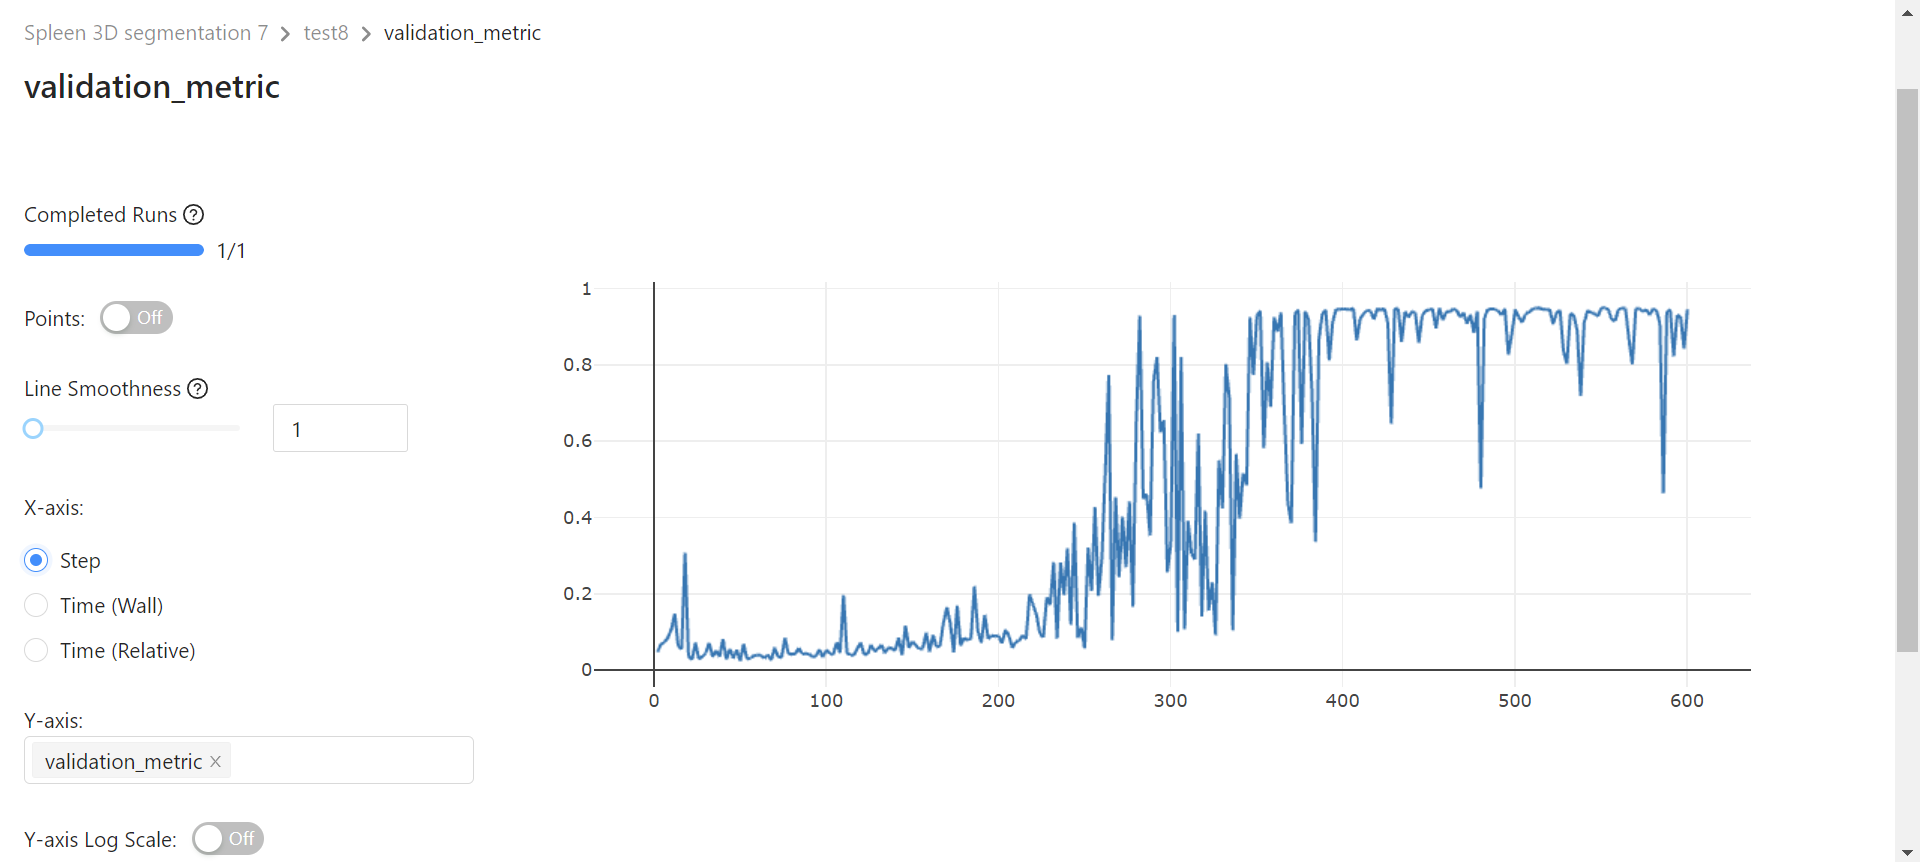

## End tracking and clean up data directory

Here, we end the MLFlow run. Remove directory if a temporary was used.

In [ ]:
mlflow.end_run()

if directory is None:
    shutil.rmtree(root_dir)

shutil.rmtree(overlay_tmp_dir)